# 3: Customer Scoring and Behavior Analysis

In this Jupyter notebook, we will conduct an exploratory data analysis of customer activities and their buying behaviors. This is a crucial aspect in the field of customer analytics. By understanding customer behaviors and patterns, businesses can develop more effective marketing strategies, improve customer service, and ultimately drive more sales.

## Overview

The main aim of this analysis is to develop a scoring model for customers based on their behavior and characteristics. Then, we'll use this model to predict future customer behavior, which in turn could help the business make informed decisions about marketing and customer relationship management strategies.

We'll be focusing on RFM (Recency, Frequency, Monetary) analysis, a popular method used in database marketing and direct marketing. RFM allows us to segment customers based on their transaction history and analyze customers by how recently they purchased (recency), how often they purchase (frequency), and how much the customer spends (monetary).

## Structure of the Notebook

The notebook begins by importing necessary libraries and defining helper functions which include functions to:

- Load sales data
- Create a retrospective snapshot of the sales data
- Calculate per customer RFM (recency, frequency, money) statistics
- Create data panel of per customer per year RFM (recency, frequency, money) statistics
- Create data panel of per customer per year Revenue summaries

We then proceed to load and create RFM and Revenue Data Panel. This involves loading the sales data, creating RFM data panel and revenue data panel, and then merging the two panels.

Next, we add target variables to the panel that we will be predicting in the subsequent analysis. These target variables include next year's revenue and whether the customer will be active or not.

Finally, we create the models for revenue and probability based on the RFM analysis, and identify the in-sample training set that we will use to train our prediction models.

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Define Helper Functions

In [31]:
"""
    Load sales data from text file
"""
def load_sales_data():
    df = pd.read_csv(
    'raw_orders.txt',
    header=None,sep='\t',
    parse_dates=[2],
    names=['customer_id','purchase_amount','date_of_purchase'])
    df['year_of_purchase'] = df.date_of_purchase.dt.year
    return df

"""
    Create a retrospective snapshot of the sales data as of a given date in the past
"""
def retro(sales_data,retrospective_date):
    retro_date = pd.to_datetime(retrospective_date)
    retro_sales_data = sales_data[sales_data.date_of_purchase < retro_date].copy()
    retro_sales_data['days_since'] = (retro_date - retro_sales_data.date_of_purchase).dt.days
    return retro_sales_data

"""
    Calculate per customer RFM (recency, frequency, money) statistics
"""
def rfm(sales_df,year=None):
    g = sales_df.groupby(by='customer_id')
    df = pd.DataFrame({
        'recency' : g.days_since.min(), 
        'first_purchase' : g.days_since.max(),
        'frequency' : g.days_since.count(), 
        'avg_amount' : g.purchase_amount.mean(),
        'max_amount' : g.purchase_amount.max()}, 
        columns= ['recency','first_purchase','frequency','avg_amount','max_amount'])
    if year:
        df['year'] = year
    return df

"""
    Create data panel of per customer per year RFM (recency, frequency, money) statistics
"""
def rfm_panel(sales_df):
    retrospective_dates = pd.to_datetime(np.sort(sales_df.date_of_purchase.dt.year.unique()) + 1,format='%Y')
    customers = pd.concat([rfm(retro(sales_df,date),date.year -1) for date in retrospective_dates])
    customers.set_index('year',append=True,inplace=True)
    customers.sort_index(inplace=True)
    return customers

"""
    Create data panel of per customer per year Revenue summaries
"""
def revenue_panel(sales_def):
    g = sales_df.groupby(by=['customer_id','year_of_purchase'])
    revenues = pd.DataFrame({'revenue' :g.purchase_amount.sum()})
    revenues.index.set_names(['customer_id','year'],inplace=True)
    return revenues

## Load and Create RFM and Revenue Data Panel

In [3]:
sales_df = load_sales_data()
sales_df.head(6)

,customer_id,purchase_amount,date_of_purchase,year_of_purchase
0,760,25.0,2009-11-06,2009
1,860,50.0,2012-09-28,2012
2,1200,100.0,2005-10-25,2005
3,1420,50.0,2009-07-09,2009
4,1940,70.0,2013-01-25,2013
5,1960,40.0,2013-10-29,2013


### Create RFM Data Panel

In [4]:
customers = rfm_panel(sales_df)
customers.head(22)

recency  first_purchase  frequency  avg_amount  max_amount
customer_id year                                                            
10          2005      177             177          1   30.000000        30.0
            2006      542             542          1   30.000000        30.0
            2007      907             907          1   30.000000        30.0
            2008     1273            1273          1   30.000000        30.0
            2009     1638            1638          1   30.000000        30.0
            2010     2003            2003          1   30.000000        30.0
            2011     2368            2368          1   30.000000        30.0
            2012     2734            2734          1   30.000000        30.0
            2013     3099            3099          1   30.000000        30.0
            2014     3464            3464          1   30.000000        30.0
            2015     3829            3829          1   30.000000        30.0
80          2005       99              99          1   50.000000        50.0
            2006      464             464          1   50.000000        50.0
            2007      258             829          2   55.000000        60.0
            2008      624            1195          2   55.000000        60.0
            2009      266            1560          3   60.000000        70.0
            2010      631            1925          3   60.000000        70.0
            2011      149            2290          4   65.000000        80.0
            2012      515            2656          4   65.000000        80.0
            2013      147            3021          5   68.000000        80.0
            2014      302            3386          6   70.000000        80.0
            2015      343            3751          7   71.428571        80.0

### Create Revenue Data Panel

In [30]:
revenues = revenue_panel(sales_df)
revenues.head()

revenue
customer_id year         
10          2005     30.0
80          2005     50.0
            2007     60.0
            2009     70.0
            2011     80.0

### Merge Revenue and RFM Panels 
We will use RFM statistics to forecast future revenue.  Therefore we create a dataset which combines revenue and RFM statistics.

In [35]:
# Join RFM and Revenue panels
if 'revenue' in customers.columns:
    customers.drop('revenue',axis=1,inplace=True)
customers = customers.join(revenues)
customers.revenue.fillna(0,inplace=True)

# Take a peek at resulting panel
customers.head()

recency  first_purchase  frequency  avg_amount  max_amount  \
customer_id year                                                               
10          2005      177             177          1        30.0        30.0   
            2006      542             542          1        30.0        30.0   
            2007      907             907          1        30.0        30.0   
            2008     1273            1273          1        30.0        30.0   
            2009     1638            1638          1        30.0        30.0   

                  next_revenue  next_is_active  revenue  
customer_id year                                         
10          2005           0.0             0.0     30.0  
            2006           0.0             0.0      0.0  
            2007           0.0             0.0      0.0  
            2008           0.0             0.0      0.0  
            2009           0.0             0.0      0.0

### Add Model Target Variables to Panel

In [34]:
# Shift revenue of next year into current years observations
# These are the two pieces of data that we will be trying to predict
customers['next_revenue'] = customers.groupby(level='customer_id').revenue.shift(-1)
customers['next_is_active'] = np.NaN
customers.loc[customers.next_revenue > 0,'next_is_active'] = 1
customers.loc[customers.next_revenue == 0,'next_is_active'] = 0

customers.head()

recency  first_purchase  frequency  avg_amount  max_amount  \
customer_id year                                                               
10          2005      177             177          1        30.0        30.0   
            2006      542             542          1        30.0        30.0   
            2007      907             907          1        30.0        30.0   
            2008     1273            1273          1        30.0        30.0   
            2009     1638            1638          1        30.0        30.0   

                  next_revenue  next_is_active  revenue  
customer_id year                                         
10          2005           0.0             0.0     30.0  
            2006           0.0             0.0      0.0  
            2007           0.0             0.0      0.0  
            2008           0.0             0.0      0.0  
            2009           0.0             0.0      0.0

## Create Revenue and Probability Models

First thing we do we identify a training set which we will use to train our prediction models.   In this case we will train our model from observations taken from the year 2014.

### Indentify In Sample Training Set

In [6]:
in_sample = customers.xs(2014,level='year')
in_sample.head()

,recency,first_purchase,frequency,avg_amount,max_amount,revenue,next_revenue,next_is_active
customer_id,,,,,,,,
10,3464,3464,1,30.0,30.0,0.0,0.0,0.0
80,302,3386,6,70.0,80.0,80.0,80.0,1.0
90,393,3418,10,115.8,153.0,0.0,0.0,0.0
120,1036,1036,1,20.0,20.0,0.0,0.0,0.0
130,2605,3345,2,50.0,60.0,0.0,0.0,0.0


### Model Probability Customer Is Active Next Year
We create a model which uses RFM statistics from the year of 2014 to predict customer activity for the year 2015.

In [7]:
import statsmodels.formula.api as smf
logit = smf.logit(
    'next_is_active ~ recency + first_purchase + frequency +avg_amount + max_amount',
    data=in_sample)
model_prob = logit.fit()
model_prob.summary()

Optimization terminated successfully.
         Current function value: 0.365836
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         next_is_active   No. Observations:                16905
Model:                          Logit   Df Residuals:                    16899
Method:                           MLE   Df Model:                            5
Date:                Wed, 26 Oct 2016   Pseudo R-squ.:                  0.3214
Time:                        10:34:20   Log-Likelihood:                -6184.5
converged:                       True   LL-Null:                       -9113.9
                                        LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -0.5331      0.044    -12.087      0.000        -0.620    -0.447
recency           -0.0020      6e-05    -32.748      0.000        -0.002    -0.002
first_purchase -1.167e-05   3.93e-05     -0.297      0.766     -8.86e-05  6.53e-05
frequency          0.2195      0.015     14.840      0.000         0.191     0.249
avg_amount         0.0004      0.000      1.144      0.253        -0.000     0.001
max_amount        -0.0002      0.000     -0.574      0.566        -0.001     0.000
==================================================================================
"""

Notice that recency and frequency coefficients are statistically significant with p-values of nearly 0 (and 95% CI which do not contain 0). 

#### Compare Predictions Against Actual Results

In [8]:
pd.DataFrame(
    model_prob.pred_table(threshold=.5).astype('int'),
    index=[['Actual','Actual'],['inactive','active']],
    columns=[['Predicted','Predicted'],['inactive','active']])

Predicted       
                 inactive active
Actual inactive     12311    708
       active        1913   1973

Not sure if this a very good classifier.  I'd need to examine the results a bit more.

#### Use Model To Predict 2016 Customer Activity
We use our probability model on 2015 observations to predict the probability of those customers being active in 2016.

In [9]:
out_sample = customers.xs(2015,level='year').copy()
out_sample['prob_predicted'] = pd.Series(model_prob.predict(out_sample),index=out_sample.index)
out_sample.drop(['revenue','next_revenue','next_is_active'],axis=1,inplace=True)
out_sample.head()

,recency,first_purchase,frequency,avg_amount,max_amount,prob_predicted
customer_id,,,,,,
10,3829,3829,1,30.000000,30.0,0.000380
80,343,3751,7,71.428571,80.0,0.575159
90,758,3783,10,115.800000,153.0,0.538104
120,1401,1401,1,20.000000,20.0,0.044037
130,2970,3710,2,50.000000,60.0,0.002568


### Model Revenues Of Active Customers
We create a model which predicts how much a customer is likely to spend if they remain active. We restrict our training sample of 2014 customers to look at only those which are active in 2015.

#### Indentify Training Set for Model

In [10]:
z = in_sample.next_is_active == 1
in_sample.ix[z,:].head()

,recency,first_purchase,frequency,avg_amount,max_amount,revenue,next_revenue,next_is_active
customer_id,,,,,,,,
80,302,3386,6,70.000000,80.0,80.0,80.0,1.0
480,16,3313,11,62.272727,235.0,45.0,45.0,1.0
830,267,3374,6,48.333333,60.0,50.0,50.0,1.0
850,62,3051,8,28.125000,30.0,30.0,60.0,1.0
860,267,3643,9,53.333333,60.0,60.0,60.0,1.0


In [11]:
in_sample.ix[z,:].describe()

,recency,first_purchase,frequency,avg_amount,max_amount,revenue,next_revenue,next_is_active
count,3886.000000,3886.000000,3886.000000,3886.000000,3886.000000,3886.000000,3886.000000,3886.0
mean,306.346372,1636.163664,4.740607,67.781735,88.328806,69.964599,92.304406,1.0
std,519.457413,1101.254072,3.786875,160.057636,222.147175,187.768354,217.448347,0.0
min,1.000000,1.000000,1.000000,5.000000,5.000000,0.000000,5.000000,1.0
25%,23.000000,649.750000,2.000000,30.000000,30.000000,10.000000,30.000000,1.0
50%,97.000000,1604.000000,4.000000,40.000000,50.000000,30.000000,50.000000,1.0
75%,328.000000,2666.000000,7.000000,60.000000,80.000000,68.750000,100.000000,1.0
max,3544.000000,3647.000000,40.000000,4500.000000,4500.000000,4500.000000,4500.000000,1.0


#### Create Linear Regression Model to Predict Spending

In [12]:
ols = smf.ols(
    formula='next_revenue ~ avg_amount + max_amount',
    data = in_sample.ix[z,:])
model_revenue = ols.fit()

In [13]:
model_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           next_revenue   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     2979.
Date:                Wed, 26 Oct 2016   Prob (F-statistic):               0.00
Time:                        10:34:20   Log-Likelihood:                -24621.
No. Observations:                3886   AIC:                         4.925e+04
Df Residuals:                    3883   BIC:                         4.927e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     20.7471      2.381      8.713      0.000        16.079    25.415
avg_amount     0.6749      0.033     20.575      0.000         0.611     0.739
max_amount     0.2923      0.024     12.367      0.000         0.246     0.339
==============================================================================
Omnibus:                     5580.836   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8162692.709
Skew:                           7.843   Prob(JB):                         0.00
Kurtosis:                     226.980   Cond. No.                         315.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Visually Inspect Model Fit
If it fits well then the actual values and the predicted values to group around the "y = x" line.

<IPython.core.display.Javascript object>


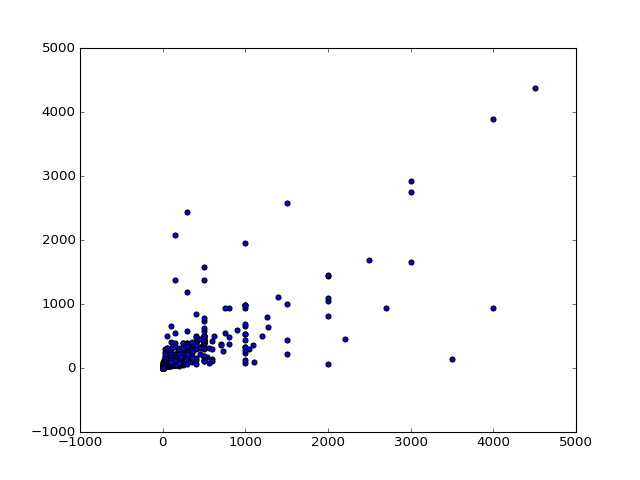

In [14]:
plt.scatter(x=in_sample.next_revenue[z],y=model_revenue.fittedvalues)

The fit doesn't look very good. 

#### To Improve Fit We Use Log(Revenue) Instead of Revenue

In [15]:
ols = smf.ols(
    formula='np.log(next_revenue) ~ np.log(avg_amount) + np.log(max_amount)',
    data = in_sample.ix[z,:])
model_revenue = ols.fit()

In [16]:
model_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(next_revenue)   R-squared:                       0.693
Model:                              OLS   Adj. R-squared:                  0.693
Method:                   Least Squares   F-statistic:                     4377.
Date:                  Wed, 26 Oct 2016   Prob (F-statistic):               0.00
Time:                          10:34:20   Log-Likelihood:                -2644.6
No. Observations:                  3886   AIC:                             5295.
Df Residuals:                      3883   BIC:                             5314.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              0.3700      0.040      9.242      0.000         0.292     0.448
np.log(avg_amount)     0.5488      0.042     13.171      0.000         0.467     0.631
np.log(max_amount)     0.3881      0.038     10.224      0.000         0.314     0.463
==============================================================================
Omnibus:                      501.505   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3328.833
Skew:                           0.421   Prob(JB):                         0.00
Kurtosis:                       7.455   Cond. No.                         42.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>


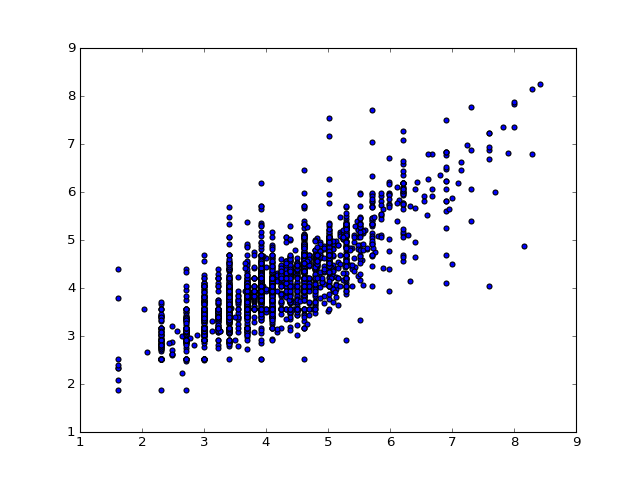

In [23]:
plt.scatter(x=np.log(in_sample.next_revenue[z]),y=model_revenue.fittedvalues)

This looks like a better fit, so we'll use this model for our predictions.

#### Apply Model to 2015 Data to Predict 2016 Revenues

In [24]:
out_sample['revenue_predicted'] = pd.Series(np.exp(model_revenue.predict(out_sample)),index=out_sample.index)
out_sample['score_predicted'] = out_sample.revenue_predicted * out_sample.prob_predicted

In [25]:
out_sample[['revenue_predicted','prob_predicted','score_predicted']].describe()

,revenue_predicted,prob_predicted,score_predicted
count,18417.000000,18417.000000,18417.000000
mean,65.632173,0.224987,18.833654
std,147.887338,0.251136,70.211180
min,6.540053,0.000263,0.003298
25%,28.999793,0.012637,0.455815
50%,35.048014,0.106187,4.556268
75%,57.298430,0.397817,17.957241
max,3832.952670,0.999904,2854.156430


## Analyze Customers Scores
For example, let's find all the customers with a score greater than 50.  These are customers which are likely to purchase more than $50 dollars worth of goods in 2016.

In [20]:
z_above_50 = out_sample.score_predicted > 50

In [21]:
out_sample.ix[z_above_50,:].head()

,recency,first_purchase,frequency,avg_amount,max_amount,prob_predicted,revenue_predicted,score_predicted
customer_id,,,,,,,,
90,758,3783,10,115.800000,153.0,0.538104,138.426136,74.487670
480,21,3678,12,60.833333,235.0,0.881374,114.848552,101.224513
1020,1,2192,5,68.000000,100.0,0.634040,87.629165,55.560381
1050,1448,3761,9,155.555556,600.0,0.186112,276.631300,51.484383
1150,10,3664,11,64.090909,85.0,0.862059,79.642129,68.656200


In [22]:
out_sample.ix[z_above_50,:].describe()

,recency,first_purchase,frequency,avg_amount,max_amount,prob_predicted,revenue_predicted,score_predicted
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000
mean,162.306647,2159.732628,6.743958,253.637002,347.737817,0.629122,276.739623,145.797056
std,250.379056,1223.317310,4.505158,456.728711,585.132233,0.196490,428.153266,222.410272
min,1.000000,1.000000,1.000000,25.952381,50.000000,0.044997,51.270986,50.000056
25%,13.000000,1100.000000,3.000000,78.333333,100.000000,0.480323,97.974797,61.370252
50%,56.000000,2356.500000,6.000000,112.500000,150.000000,0.646999,137.867182,79.961431
75%,231.000000,3252.750000,9.000000,200.000000,300.000000,0.793240,225.637094,129.043543
max,1847.000000,4010.000000,45.000000,4500.000000,4500.000000,0.999904,3832.952670,2854.156430


We found 1324 customers which are predicted to purchase more than $50 dollars worth of goods in 2016.